In [14]:
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

import pywt

def values(func, left, right, n):
    return func(np.linspace(left, right, n))

Функция для TT-SVD (копирую из домашки):

In [8]:
def tt_svd(tensor, eps, max_rank):
    """
    Input
        tensor: np array
        eps: desired difference in frobenius norm between tensor and TT approximation
        max_rank: upper hard limit on each TT rank (it has priority over eps)

    Output
        carriages: list of cores that give TT decomposition of tensor
    """

    remaining = tensor
    d = len(tensor.shape)
    N = tensor.size
    r = 1

    eps = eps / np.sqrt(d - 1) #потому что ошибка в tt_svd составляет
    #sqrt(sum_{k <= d - 1} квадрат ошибки в svd для A_k) = sqrt(d - 1) * ошибка в каждом svd

    carriages = []

    for k in range(d - 1):
        matrix_to_svd = remaining.reshape((r * tensor.shape[k], N // tensor.shape[k]), order='F')
        u, sigmas, vt = np.linalg.svd(matrix_to_svd, full_matrices=False)

        curr_r = min(sigmas.size, max_rank)
        error_squared = np.sum(np.square(sigmas[curr_r:]))
        while curr_r >= 1 and error_squared + np.square(sigmas[curr_r - 1]) < np.square(eps):
            error_squared = error_squared + np.square(sigmas[curr_r - 1])
            curr_r -= 1

        carriages.append(u[:,:curr_r].reshape((r, tensor.shape[k], curr_r), order='F'))
        remaining = np.diag(sigmas[:curr_r]) @ vt[:curr_r,:]
        N = N // tensor.shape[k]
        r = curr_r

    carriages.append(remaining.reshape((r, tensor.shape[-1], 1), order='F'))

    return carriages

Базовые штуки.

In [9]:
def wtt_filter(input_vector, d, modes, ranks=None, eps=None, check_correctness=False):
    assert ranks is not None or eps is not None
    
    filters = []
    prod_modes = input_vector.size
    
    if check_correctness:
        assert len(modes) == d
        if ranks is not None:
            assert len(ranks) == d - 1
        if eps is not None:
            assert eps > 0
        assert prod_modes == np.prod(modes)
        
    true_ranks = []
    
    r_prev = 1
    A = input_vector
    for k in range(d):
        A = A.reshape((r_prev * modes[k], prod_modes // modes[k]), order='F')
        if A.shape[0] <= A.shape[1]:
            u, sigmas, vt = np.linalg.svd(A, full_matrices=False)
        else:
            u, sigmas, vt = np.linalg.svd(A, full_matrices=True)
            
        r_given = None if ranks is None else (1 if k == d - 1 else ranks[k])
        r_eps = None if eps is None else max(1, (sigmas >= eps * sigmas[0]).sum())
        if r_given is not None and r_eps is not None:
            r_cur = min(r_given, r_eps)
        elif r_given is not None:
            r_cur = r_given
        else:
            r_cur = r_eps
        
        filters.append(u)

        if check_correctness:
            assert u.shape[0] == u.shape[1] == r_prev * modes[k]
            if k < d - 1:
                assert r_cur <= r_prev * modes[k]

        if k < d - 1:
            A = (u.T @ A)[:r_cur,:]
            prod_modes //= modes[k]
            true_ranks.append(r_cur)
            r_prev = r_cur
    
    return filters, true_ranks

In [10]:
def wtt_apply(input_vector, d, filters, modes, ranks, check_correctness=False):
    prod_modes = input_vector.size
    
    if check_correctness:
        assert len(filters) == d
        assert len(modes) == d
        assert len(ranks) == d - 1
        assert prod_modes == np.prod(modes)
        
    tails = []
    A = input_vector
    r_prev = 1
    for k in range(d):
        A = A.reshape((r_prev * modes[k], prod_modes // modes[k]), order='F')
        A = filters[k].T @ A

        if check_correctness:
            assert A.shape[0] == r_prev * modes[k]
            if k < d - 1:
                assert ranks[k] <= r_prev * modes[k]
                
        if k < d - 1:
            tails.append(A[ranks[k]:,:])
            A = A[:ranks[k],:]
            prod_modes //= modes[k]
            r_prev = ranks[k]
        
    result = A
    for k in range(d - 2, -1, -1):        
        result = np.vstack([
            result.reshape((ranks[k], prod_modes), order='F'),
            tails[k]
        ])
        prod_modes *= modes[k]
    
    return result.flatten(order='F')

In [11]:
def iwtt_apply(input_vector, d, filters, modes, ranks, check_correctness=False):
    prod_modes = input_vector.size
    
    if check_correctness:
        assert len(filters) == d
        assert len(modes) == d
        assert len(ranks) == d - 1
        assert prod_modes == np.prod(modes)
        
    tails = []
    A = input_vector
    r_prev = 1
    for k in range(d):
        A = A.reshape((r_prev * modes[k], prod_modes // modes[k]), order='F')

        if check_correctness:
            assert A.shape[0] == r_prev * modes[k]
            if k < d - 1:
                assert ranks[k] <= r_prev * modes[k]
                
        if k < d - 1:
            tails.append(A[ranks[k]:,:])
            A = A[:ranks[k],:]
            prod_modes //= modes[k]
            r_prev = ranks[k]
        
    #prod_modes == modes[-1] в конце
    result = A
    for k in range(d - 1, -1, -1):
        
        r_prev = 1 if k == 0 else ranks[k - 1]
        if k == d - 1:
            result = (filters[k] @ result).reshape((r_prev, prod_modes), order='F')
        else:
            result = (filters[k] @ np.vstack([
                result,
                tails[k]
            ])).reshape((r_prev, prod_modes), order='F')
        prod_modes *= modes[k]
    
    return result.flatten(order='F')

In [12]:
def matrix_to_vector(A, d, modes, check_correctness=False):
    if check_correctness is True:
        assert A.shape[0] == A.shape[1] == np.prod(modes)
        assert len(modes) == d
    result = np.reshape(A, modes + modes, order='F')
    axes_transpose = []
    for i in range(d):
        axes_transpose.append(i)
        axes_transpose.append(d + i)
    result = np.transpose(result, axes_transpose)
    new_modes = [m ** 2 for m in modes]
    result = np.reshape(result, new_modes, order='F')
    return result.flatten(order='F'), new_modes

def vector_to_matrix(v, d, modes, check_correctness=False):
    if check_correctness is True:
        assert v.size == np.prod(modes)
        assert len(modes) == d
    new_modes = [int(np.sqrt(m)) for m in modes]
    if check_correctness is True:
        assert np.all(modes == np.square(new_modes))
    result = np.reshape(v, new_modes + new_modes, order='F')
    axes_transpose = []
    for i in range(d):
        axes_transpose.append(2 * i)
    for i in range(d):
        axes_transpose.append(2 * i + 1)
    result = np.transpose(result, axes_transpose)
    result = np.reshape(result, (np.prod(new_modes), np.prod(new_modes)), order='F')
    return result, new_modes

Версия с частичным преобразованием. Теперь длина фильтров и рангов может быть меньше. Длина ```modes``` остаётся какой была.

In [13]:
def wtt_filter_maxlevel(input_vector, d, modes, ranks=None, eps=None, maxlevel=None, check_correctness=False):
    assert ranks is not None or eps is not None
    
    filters = []
    prod_modes = input_vector.size
    
    if check_correctness:
        assert len(modes) == d
        if ranks is not None:
            assert len(ranks) == d - 1
        if eps is not None:
            assert eps > 0
        assert prod_modes == np.prod(modes)
        
    true_ranks = []
    
    numberOfFilters = d if maxlevel is None else min(d, maxlevel)
    assert 0 < numberOfFilters <= d
    
    r_prev = 1
    A = input_vector
    for k in range(numberOfFilters):
        A = A.reshape((r_prev * modes[k], prod_modes // modes[k]), order='F')
        if A.shape[0] <= A.shape[1]:
            u, sigmas, vt = np.linalg.svd(A, full_matrices=False)
        else:
            u, sigmas, vt = np.linalg.svd(A, full_matrices=True)
            
        r_given = None if ranks is None else (1 if k == d - 1 else ranks[k])
        r_eps = None if eps is None else max(1, (sigmas >= eps).sum())
        if r_given is not None and r_eps is not None:
            r_cur = min(r_given, r_eps)
        elif r_given is not None:
            r_cur = r_given
        else:
            r_cur = r_eps
        
        filters.append(u)

        if check_correctness:
            assert u.shape[0] == u.shape[1] == r_prev * modes[k]
            if k < d - 1:
                assert r_cur <= r_prev * modes[k]

        if k < numberOfFilters - 1:
            A = (u.T @ A)[:r_cur,:]
            prod_modes //= modes[k]
            true_ranks.append(r_cur)
            r_prev = r_cur
    
    return filters, true_ranks
    #теперь len(filters) это numberOfFilters

def wtt_apply_maxlevel(input_vector, filters, modes, ranks, check_correctness=False):
    prod_modes = input_vector.size
    numberOfFilters = len(filters)
    if check_correctness:
        assert 0 < numberOfFilters <= len(modes)
        assert len(ranks) == numberOfFilters - 1
        assert prod_modes == np.prod(modes)
        
    tails = []
    A = input_vector
    r_prev = 1
    for k in range(numberOfFilters):
        A = A.reshape((r_prev * modes[k], prod_modes // modes[k]), order='F')
        A = filters[k].T @ A

        if check_correctness:
            assert A.shape[0] == r_prev * modes[k]
            if k < numberOfFilters - 1:
                assert ranks[k] <= r_prev * modes[k]
                
        if k < numberOfFilters - 1:
            tails.append(A[ranks[k]:,:])
            A = A[:ranks[k],:]
            prod_modes //= modes[k]
            r_prev = ranks[k]
        
    result = A
    for k in range(numberOfFilters - 2, -1, -1):        
        result = np.vstack([
            result.reshape((ranks[k], prod_modes), order='F'),
            tails[k]
        ])
        prod_modes *= modes[k]
    
    return result.flatten(order='F')

def iwtt_apply_maxlevel(input_vector, filters, modes, ranks, check_correctness=False):
    prod_modes = input_vector.size
    numberOfFilters = len(filters)
    if check_correctness:
        assert 0 < numberOfFilters <= len(modes)
        assert len(ranks) == numberOfFilters - 1
        assert prod_modes == np.prod(modes)
        
    tails = []
    A = input_vector
    r_prev = 1
    for k in range(numberOfFilters):
        A = A.reshape((r_prev * modes[k], prod_modes // modes[k]), order='F')

        if check_correctness:
            assert A.shape[0] == r_prev * modes[k]
            if k < numberOfFilters - 1:
                assert ranks[k] <= r_prev * modes[k]
                
        if k < numberOfFilters - 1:
            tails.append(A[ranks[k]:,:])
            A = A[:ranks[k],:]
            prod_modes //= modes[k]
            r_prev = ranks[k]
        
    #prod_modes == modes[-1] в конце
    result = A
    for k in range(numberOfFilters - 1, -1, -1):
        
        r_prev = 1 if k == 0 else ranks[k - 1]
        if k == numberOfFilters - 1:
            result = (filters[k] @ result).reshape((r_prev, prod_modes), order='F')
        else:
            result = (filters[k] @ np.vstack([
                result,
                tails[k]
            ])).reshape((r_prev, prod_modes), order='F')
        prod_modes *= modes[k]
    
    return result.flatten(order='F')

In [17]:
original = pywt.data.camera()
print(original.shape)

d = 9
n = 2 ** d
modes = [2] * d

img_tensorised, vector_modes = matrix_to_vector(original, d, modes, True)
assert vector_modes == [4] * d

(512, 512)


In [40]:
eps = 1e-2
filters, true_ranks = wtt_filter(img_tensorised, d, vector_modes, eps=eps)
true_ranks

[3, 7, 15, 31, 46, 35, 14, 4]

In [41]:
tmp = filters[0].T @ img_tensorised.reshape((4, -1), order='F')
approx = tmp[:3]
details = tmp[3:]

approx = np.vstack([
    approx,
    np.zeros((1, tmp.shape[1]))
])

In [47]:
approx, _ = vector_to_matrix(tmp, d, vector_modes)

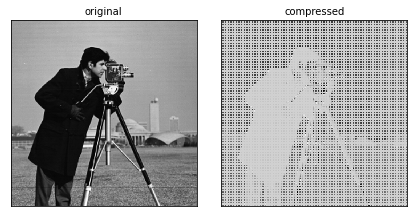

In [48]:
fig = plt.figure(figsize=(6, 3))
titles = ["original", "compressed"]
for i, a in enumerate([original, approx]):
    ax = fig.add_subplot(1, 2, i + 1)
    ax.imshow(a, interpolation="nearest", cmap=plt.cm.gray)
    ax.set_title(titles[i], fontsize=10)
    ax.set_xticks([])
    ax.set_yticks([])

fig.tight_layout()
plt.show()